In [1]:
import pandas as pd
import unicodedata 
import string
from nltk.stem.porter import *
import unicodedata 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.stem.wordnet import WordNetLemmatizer


In [2]:
movies_data = pd.read_table("train.tsv")
movies_data.shape
movies_data["Sentiment"].unique()
                    

array([1, 2, 3, 4, 0])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [65]:
movie_test = pd.read_table("test.tsv")
movie_test.shape



(66292, 3)

In [30]:
movies_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [66]:
movies_data['Phrase'] = (movies_data['Phrase'].str.lower()
              .str.decode('utf-8')
              .map(lambda x: unicodedata.normalize('NFKD', x))
              .str.encode('ascii', 'ignore'))

movie_test['Phrase'] = (movie_test['Phrase'].str.lower()
              .str.decode('utf-8')
              .map(lambda x: unicodedata.normalize('NFKD', x))
              .str.encode('ascii', 'ignore'))

In [67]:
cols = ["Phrase", "Sentiment"]
movies_data_new =movies_data[cols]

In [68]:
movies_data_new.to_csv("train.csv", index= False)
movie_test.to_csv("test.csv", index= False)

In [69]:
import csv
with open("test.csv", 'r') as file: 
    test = list(csv.reader(file))

print(len(test))

66293


In [70]:
import csv
with open("train.csv", 'r') as file: 
    reviews = list(csv.reader(file))



In [293]:
#reviews

In [78]:
def get_text(reviews, score):
    # Join together the text in the reviews for a particular tone.
    #We lowercase to avoid "Not" and "not" being seen as different words, for example.

    return "\n".join([r[0].lower() for r in reviews if r[1] == str(score)])

In [79]:
negative_text = get_text(reviews, 0)
somewhat_negative_text = get_text(reviews, 1)
neutral_text = get_text(reviews, 2)
somewhat_positive_text = get_text(reviews, 3)
positive_text = get_text(reviews, 4)



In [80]:
def stop_words(text):
    text = ' '.join([word for word in text.split() if word not in stop])
    return text

 

In [81]:
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in set(string.punctuation)])
    return s



In [330]:
#negative_text = stop_words(negative_text)
#negative_text = remove_punctuation(negative_text)

#positive_text = stop_words(positive_text)
#positive_text = remove_punctuation (positive_text)

#somewhat_negative_text = stop_words(somewhat_negative_text)
#somewhat_negative_text = remove_punctuation(somewhat_negative_text)

#somewhat_positive_text = stop_words(somewhat_positive_text)
#somewhat_positive_text = remove_punctuation (somewhat_positive_text)

#neutral_text = stop_words(neutral_text)
#neutral_text = remove_punctuation (neutral_text)

In [371]:
#neutral_text

In [82]:
with open("positive_text.txt", "w") as text_file:
    text_file.write(positive_text + "\n")

In [83]:
with open("negative_text.txt", "w") as text_file:
    text_file.write(negative_text + "\n")

In [84]:
with open("somewhat_negative_text.txt", "w") as text_file:
    text_file.write(somewhat_negative_text + "\n")

In [85]:
with open("neutral_text.txt", "w") as text_file:
    text_file.write(neutral_text + "\n")

In [86]:
with open("somewhat_positive_text.txt", "w") as text_file:
    text_file.write(neutral_text+ "\n")

LSTM

In [2]:
from __future__ import unicode_literals
import os
import nltk
import pandas as pd
import string
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
np.random.seed(1337)  # For Reproducibility
import multiprocessing
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from utils import *
import glob
from nltk.stem.porter import *
import string
import unicodedata
from joblib import Parallel, delayed
import tqdm
import keras
import gensim

Using TensorFlow backend.


In [44]:
def load_data():
    from sklearn.model_selection import train_test_split
    import io
    sentences_pos = []
    ff = "positive_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_pos.append(line)
    sentences_neg = []
    ff = "negative_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_neg.append(line)
    
    sentences_smwn = []
    ff = "somewhat_negative_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_smwn.append(line)
            
    sentences_smwp = []    
    ff = "somewhat_positive_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_smwp.append(line)
            
    sentences_neutral = []        
    ff = "neutral_text.txt"
    with io.open(ff, 'r', encoding='utf8') as f:
        for line in f:
            sentences_neutral.append(line)
            
            
    X = sentences_pos+sentences_neg+sentences_smwn+sentences_neutral+sentences_smwp
    y = [4]*len(sentences_pos)+[0]*len(sentences_neg)+[1]*len(sentences_smwn)+[2]*len(sentences_neutral) + [3]*len(sentences_smwp)
    return X, y

In [45]:
X, y = load_data()
len(X)

202715

In [46]:
def stemmering_sentences(sentence):
    # Remove punctuation, stopword and then stemmering
    punctuation = set(string.punctuation)
    stemmer = nltk.PorterStemmer()
    lmtzr = WordNetLemmatizer()
    # tmp = unicode(sentence, errors='ignore')
    tmp = sentence
    doc = [stemmer.stem(word.lower()) for word in nltk.word_tokenize(tmp) if
           (word not in punctuation) and (word not in nltk.corpus.stopwords.words('english')) and (word != 'br')]
    return doc

def stemming(X, y):
    sentences_stem = Parallel(n_jobs=4)(delayed(stemmering_sentences)(sentence) for sentence in tqdm.tqdm(X, desc="stem"))
    return sentences_stem, y

In [47]:
X, y = stemming(X, y)

stem: 100%|██████████| 202715/202715 [01:34<00:00, 2138.92it/s]


In [123]:
#X

In [58]:
# set parameters:
vocab_dim = 20
maxlen = 20
n_iterations = 20 # ideally more..
# Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. 
n_exposures = 10
window_size = 10
batch_size = 128
n_epoch = 5
input_length = 20
cpu_count = multiprocessing.cpu_count()


In [59]:
# combine_train_test_X = terms_by_doc_train + terms_by_doc_test
combine_train_test_X = X

In [60]:
print('Training a Word2vec model...')
bigram = gensim.models.Phrases(combine_train_test_X)
#bigram_transformer = gensim.models.Phrases(X)
a = list(bigram[bigram[combine_train_test_X]])
                   
model = Word2Vec(size=vocab_dim,
                 min_count=n_exposures,
                 window=window_size,
                 workers=cpu_count,
                 iter=n_iterations)
model.build_vocab(a)
model.train(a)

                  
    

Training a Word2vec model...


9064600

In [61]:
gensim_dict = Dictionary()
gensim_dict.doc2bow(model.vocab.keys(), allow_update=True)
# gensim_dict.items() returns [(0, u"'surpris"), (1, u'woodi'), (2, u'yellow'),...]
# K+1 aims at avoiding 0 as index.
w2indx = {v: k+1 for k, v in gensim_dict.items()}
w2vec = {word: model[word] for word in w2indx.keys()}
# print len(model["surpris"]) -> 100
print('Setting up Arrays for Keras Embedding Layer...')
n_symbols = len(w2indx) + 1  # adding 1 to account for 0th index
embedding_weights = np.zeros((n_symbols + 1, vocab_dim))
for word, index in w2indx.items():
    embedding_weights[index, :] = w2vec[word]
print embedding_weights.shape 

Setting up Arrays for Keras Embedding Layer...
(11179, 10)


In [62]:
from sklearn.model_selection import train_test_split
terms_by_doc_train, terms_by_doc_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train = []
for doc in terms_by_doc_train:
    new_txt = []
    for word in doc:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    X_train.append(new_txt)
X_test = []
for doc in terms_by_doc_test:
    new_txt = []
    for word in doc:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    X_test.append(new_txt)

In [63]:
print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('X_train shape:',  y_train.shape)
print('X_test shape:', y_test.shape)

Pad sequences (samples x time)
(u'X_train shape:', (141900, 20))
(u'X_test shape:', (60815, 20))
(u'X_train shape:', (141900,))
(u'X_test shape:', (60815,))


In [64]:
from keras.objectives import  categorical_crossentropy

def loss_fct(y_true, y_pred):
    
    
    # l2 = 0.001 * (model.layers[0].W**2).sum()
    l2 = 0
    return categorical_crossentropy(y_true, y_pred) + l2



In [110]:
from keras import backend as K
import numpy as np

def my_init(shape, name=None):
    value = np.sqrt(6/np.random.random(shape))
    return K.variable(value, name=name)

#w = np.random.normal(loc=0.0, scale=sigma/np.sqrt(nn_arch[i]), size=(nn_arch[i+1],nn_arch[i]))

In [ ]:
print('Defining a Simple Keras Model...')
model = Sequential()  # or Graph or whatever
model.add(Embedding(input_dim=n_symbols + 1,
                    output_dim=vocab_dim,
                    mask_zero=True,
                    weights=[embedding_weights],
                    input_length=input_length))  # Adding Input Length




#input_length=input_length))  # Adding Input 


model.add(LSTM(vocab_dim ,dropout_W=0.2, dropout_U=0.2 ))
#model.add(Dropout(12))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='relu'))

sgd = keras.optimizers.SGD(lr=0.01, momentum=0.1, decay=0, nesterov=True)
adam = keras.optimizers.Adam(lr=0.2, beta_1=0.2, beta_2=0.2, epsilon=0.1, decay=0.5)
adamax = keras.optimizers.Adamax(lr=0.2, beta_1=0.2, beta_2=0.2, epsilon=0.1 ,decay=0)
prop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0)

print('Compiling the Model...')


model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['accuracy'])

print("Train...")
history  = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20,
          validation_data=(X_test, y_test))

print("Evaluate...")
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

In [27]:
print('Test score:', score)
print('Test accuracy:', acc)

(u'Test score:', 0.63571724578031319)
(u'Test accuracy:', 0.42162295486555967)


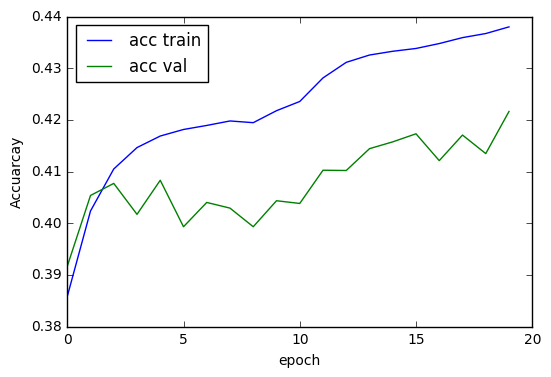

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'],label = 'acc train')
plt.plot(history.history['val_acc'],label = 'acc val')



plt.xlabel("epoch")
plt.ylabel("Accuarcay")

plt.legend(loc='best')
plt.show()
